In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motion classification with time series using deep learning

> Classify between chaotic, rotational and librational motion using the evolution of the coordinates x and y in the Poincare map

In [ ]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    !pip install git+https://github.com/fastai/fastcore.git@master -q
    !pip install git+https://github.com/fastai/fastai2.git@master -q
    !pip install git+https://github.com/ai-fast-track/timeseries.git -q
    
    base_path = Path.home() # * TODO: test this
else:
    base_path = Path.home()

In [ ]:
from fastai2.basics import *
from timeseries.all import *
from mlchaos.all import *

## Loading and splitting the data into traiing and validation

The data must be loaded as a `TSDataChaos` object, created from a pair (or a sequence of pairs) of files:
1. The first file of the pair contains the data of the Poincare map
2. The second file of the pair contains the index of the motion (0.0, 1.0 or 2.0)

In [ ]:
fnames = (base_path/'data/first_dataset/Poincare.plt', base_path/'data/first_dataset/index.plt')
data = TSDataChaos.from_poincare_and_index_files(fnames)
data

TSDataChaos:
 Datasets names (concatenated): ['first_dataset']
 Filenames:                     [(Path('/home/user/data/first_dataset/Poincare.plt'), Path('/home/user/data/first_dataset/index.plt'))]
 Data shape: (10201, 2, 100)
 Targets shape: (10201,)
 Nb Samples: 10201
 Nb Channels:           2
 Sequence Length: 100

By default we use 80% random items from the data as training and 20% as validation

In [ ]:
splits = RandomSplitter()(range_of(data.get_items()))
splits

((#8161) [9147,6612,7223,5527,3146,2044,8360,296,9449,2316...],
 (#2040) [4195,7457,9404,10109,2127,5244,6643,3209,6760,5398...])

##  Creating a `Datasets` object

In [ ]:
lbl_dict = dict([
    ('0.0', 'chaotic'),   
    ('1.0', 'rotational'),   
    ('2.0', 'librational')]
)

In [ ]:
tfms = [[ItemGetter(0), ToTensorTS(), ToTensorMotion()], # x transforms
        [ItemGetter(1), lbl_dict.get, Categorize()]] # y transforms

In [ ]:
ds = Datasets(items=data.get_items(), tfms=tfms, splits=splits)

Show one element of the dataset. Channel 0 of the time series is the x coordinate, and chhanel 1 is the y coordinate.

librational


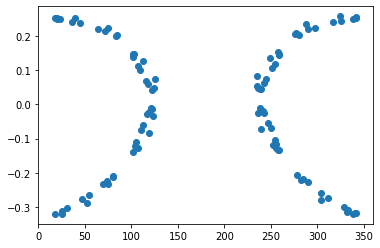

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1))

It can be useful to visualize the motions with he same y limits. We take them from the training set

In [ ]:
ylim = [data.x[:, 1].min(), data.x[:, 1].max()]
ylim

[-0.6429006050527629, 1.6429006050529]

librational


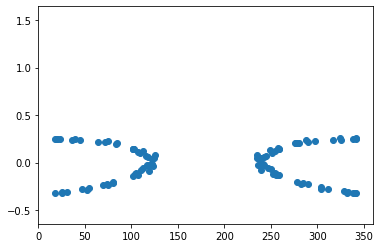

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1), ylim=ylim)

## Creating a `Dataloaders` object using the `Datasets` object

In [ ]:
bs = 256                            
# Normalize at batch time
tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = []

dls = ds.dataloaders(bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

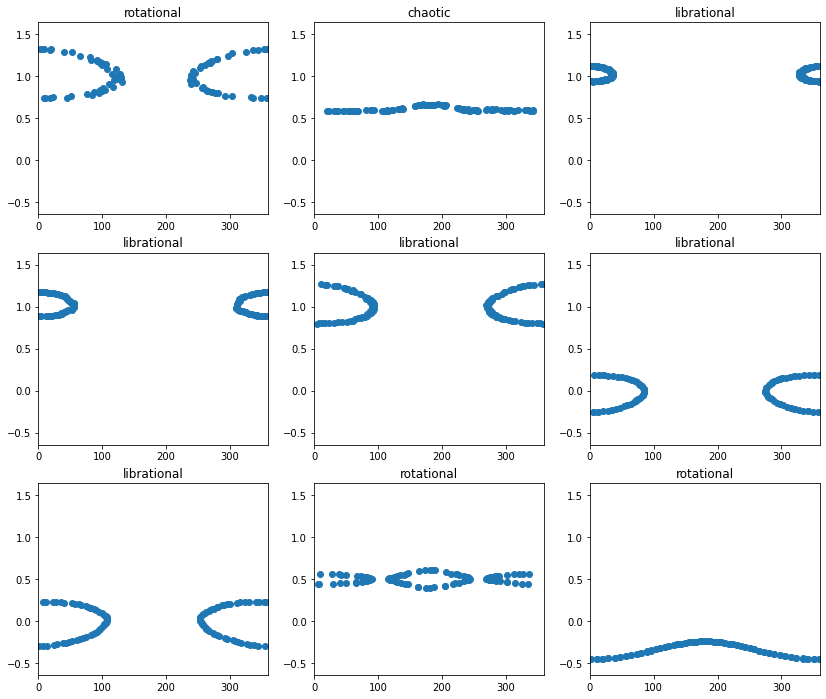

In [ ]:
dls.show_batch(max_n=9, ylim=ylim, return_fig=False)

In [ ]:
xb, yb = dls.one_batch()
print(xb[0].mean(axis=1), xb[0].std(axis=1))

tensor([180.4167,  -0.5310], device='cuda:0') tensor([1.0171e+02, 5.5048e-02], device='cuda:0')


## Training a model 

In [ ]:
# Number of channels
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(2, 3)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(2, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(2, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(2, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(2, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), 

### Creating a Learner object

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner    
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)
# learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['256 x 2 x 100'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               256 x 32 x 100       2,496      True      
________________________________________________________________
Conv1d               256 x 32 x 100       1,216      True      
________________________________________________________________
Conv1d               256 x 32 x 100       576        True      
________________________________________________________________
MaxPool1d            256 x 2 x 100        0          False     
________________________________________________________________
Conv1d               256 x 32 x 100       64         True      
________________________________________________________________
BatchNorm1d          256 x 128 x 100      256        True      
________________________________________________________________
ReLU                 256 x 128 x 100      0          False     
______________________________________________________

(0.19054607152938843, 0.0004786300996784121)

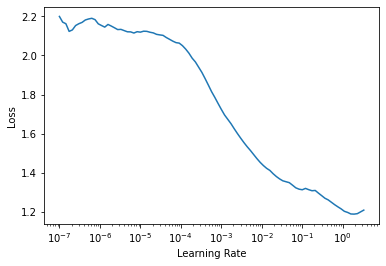

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

epoch,train_loss,valid_loss,accuracy,time
0,1.096088,0.735442,0.729412,00:07
1,0.730012,0.542474,0.852941,00:07
2,0.593484,0.739791,0.804412,00:07
3,0.522630,0.485236,0.885294,00:07
4,0.477663,0.503257,0.875000,00:07
5,0.448450,0.446451,0.910784,00:07
6,0.420339,0.444964,0.908824,00:07
7,0.394267,0.433269,0.917157,00:07
8,0.369503,0.432773,0.918627,00:07
9,0.351922,0.433236,0.919118,00:07


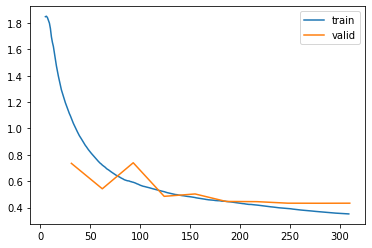

In [ ]:
learn.fit_one_cycle(10, lr_max=5e-3)
learn.recorder.plot_loss()

## Showing results

### Results for random items in the validation set 

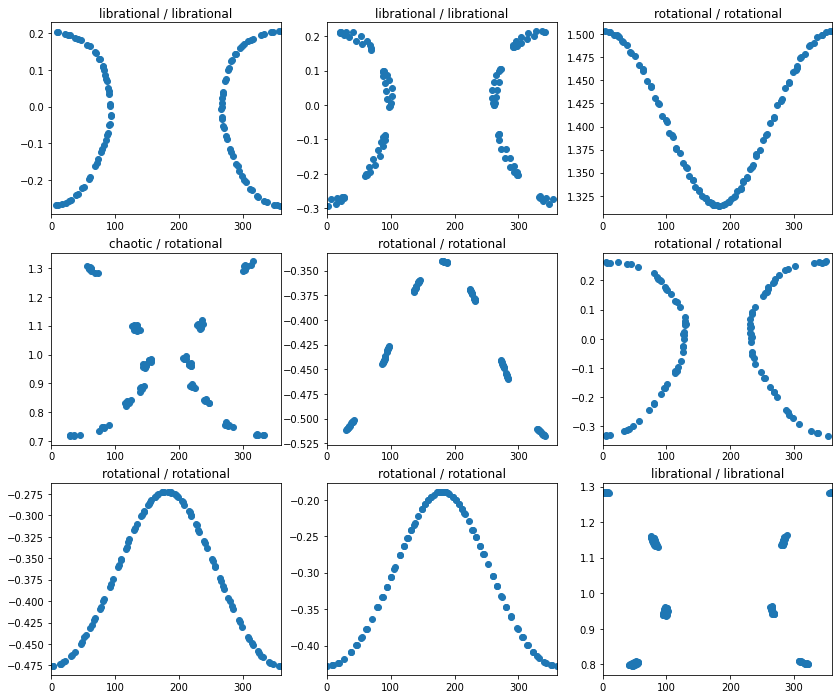

In [ ]:
learn.show_results(max_n=9)

### Showing the confusion matrix

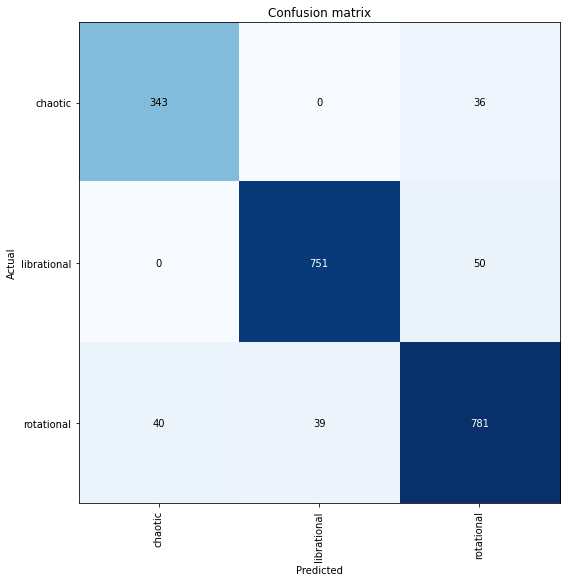

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

### Smallest errors

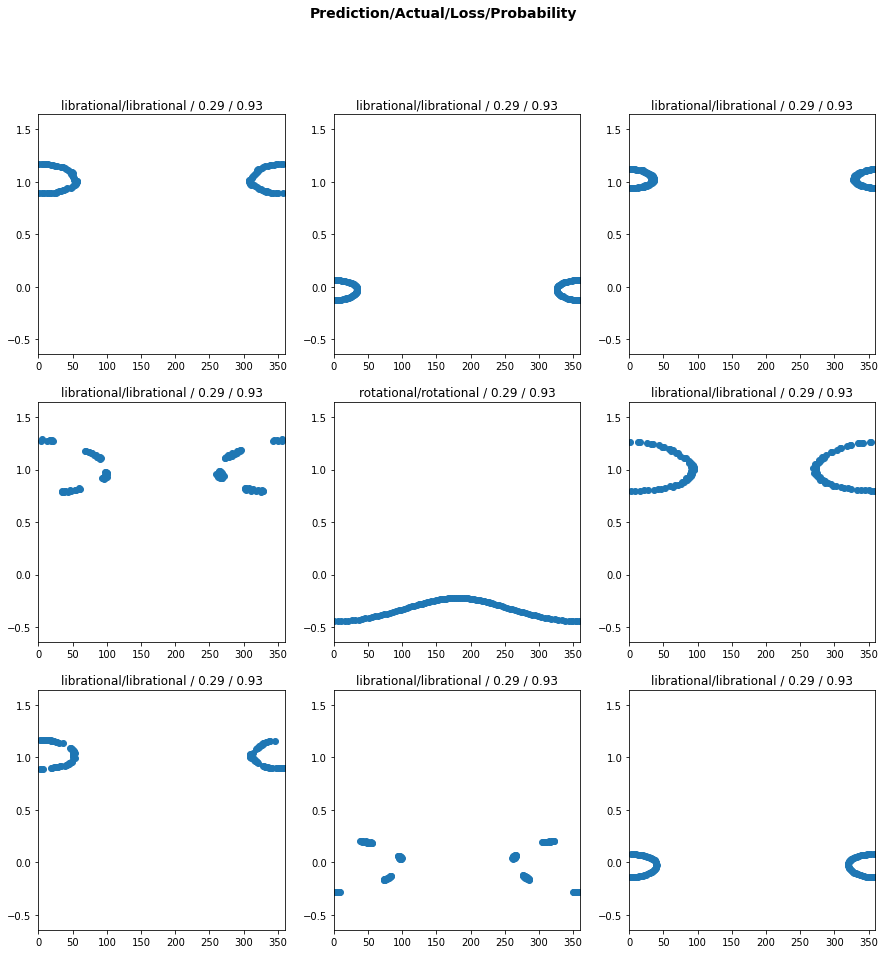

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=False, ylim=ylim)

### Largest errores

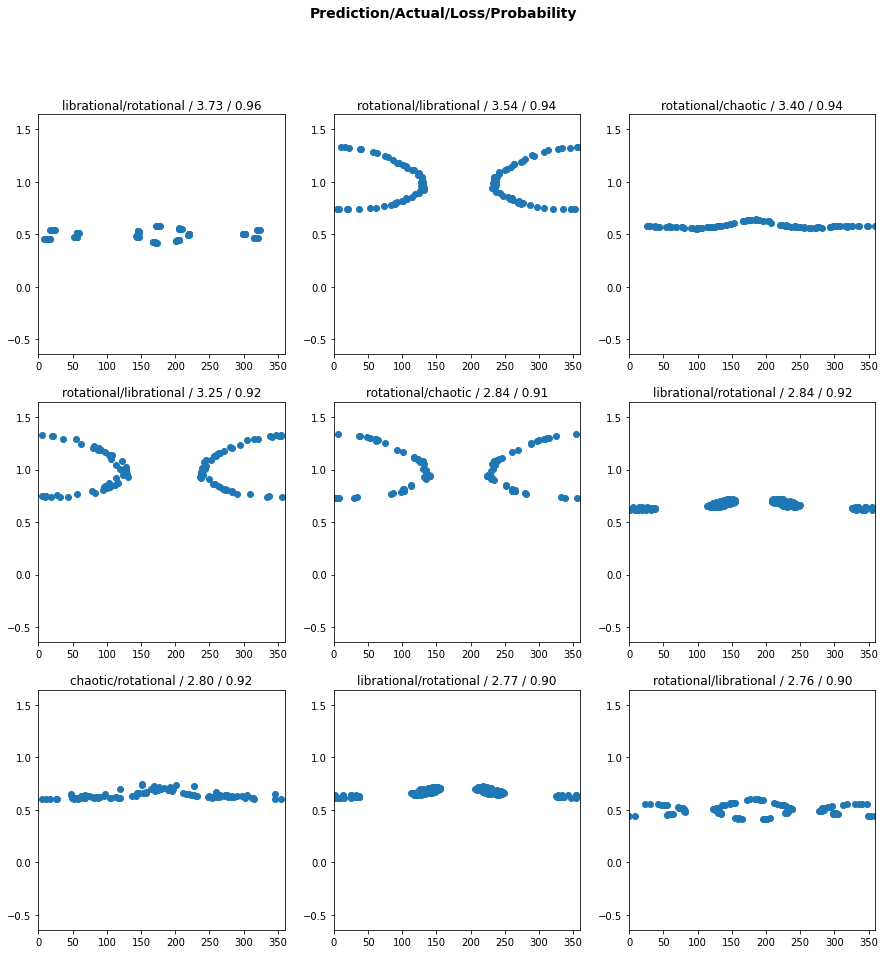

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=True, ylim=ylim)